In [1]:
import numpy as np

import pandas as pd
import sys, os, time
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

sys.path.append('../')

from src.data_structures import FactorGraph, PriorityQueue
from src.sampling_algorithms.factor_components import (gaussian_bounce, chain_bounce_fn, 
                                                       gaussian_grad_potential_fn, 
                                                       gaussian_chain_grad_potential_fn,
                                                       logistic, 
                                                       generate_logistic_bounce, 
                                                       alias_sample, 
                                                       lambda_r, 
                                                       grad_logistic, 
                                                       lambda_bound
                                                      )
from src.utils import (interp, get_xtv, get_first_moment, get_second_moment, get_var)
from src.sampling_algorithms import LocalBPS
from src.plots.arrow_plot import arrow_plot
from arviz.stats import ess

from matplotlib import rc
rc('text', usetex=False)

In [41]:
d = 5
T = 5
N = 100

covs = []
for i in range(d):
    for j in range(i+1, d):
        row = np.zeros(d)
        row[[i,j]]=1
        covs.append(row)
covs = np.array(xs)

betas = []
beta = np.random.randn(d)
betas.append(beta)

observations = []
a = 0.5

for t in range(T):

    beta = a*beta + np.random.randn(d)
    betas.append(beta)
       
    p = logistic(covs.dot(beta))
    y = (np.random.random() < p)+0.
    observations.append(y)

observations = np.array(observations)

covs = np.array([covs for _ in range(T)])

In [34]:
cov_p = np.maximum(0., covs)
cov_n = -np.minimum(0., covs)
sign = np.expand_dims((-1.)**(observations), -1)

In [42]:
mu0 = np.array([0. for _ in range(d)])
sig0 = np.diag([1. for _ in range(d)])
mu1 = np.array([0. for _ in range(d)])
sig1 = 2.*sig0

global_event_samplers = []
local_event_samplers = []
sigs = []

for t in range(T-1):
    if t == 0:
        sigs.append(2*sig0)
        global_event_samplers.append(chain_bounce_fn(mu1, mu0, sig1, sig0, sig10))
        grad_fns.append(gaussian_chain_grad_potential_fn(mu1, mu0, sig1, sig10, sig0))
    else:
        sigs.append(sigs[t-1] + sig0)
        global_event_samplers.append(chain_bounce_fn(mu1, mu0, sig1, sig0, sig10))
        grad_fns.append(gaussian_chain_grad_potential_fn(mu1, mu0, sigs[t], sigs[t-1], sigs[t-1]))
        
    local_event_samplers.append(alias_sample(t, cov_n, cov_p, covs, sign, ys))
                        
    
    
bounce_fns = [gaussian_bounce(mu0, sig0)] + global_event_samplers + local_event_samplers

grad_factor_potential_fns = [gaussian_grad_potential_fn(mu0, sig0)] + \
[gaussian_chain_grad_potential_fn(mu1, mu0, sig1, sig10, sig0) for _ in range(T-1)] + \
[grad_logistic(covs[g], ys[g]) for g in range(T)]


factor_indices = [[i for i in range(d)]] + \
                 [[t*d+i for i in range(d)]+[(t+1)*d+i for i in range(d)] for t in range(T-1)] + \
                 [[d*t+i for i in range(d)] for t in range(T)] 

factor_potential_fns = [lambda x: x for _ in grad_factor_potential_fns]

nodes = list(set(n for f in factor_indices for n in f ))


graph = FactorGraph(dim_x=len(nodes),
                  factor_indices=factor_indices,
                  factor_potential_fns=factor_potential_fns,
                  grad_factor_potential_fns=grad_factor_potential_fns)

In [43]:
factor_indices

[[0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 [0, 1, 2, 3, 4],
 [5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14],
 [15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [44]:
init_x = np.random.randn(len(nodes))
init_v = np.random.randn(len(nodes))
local_bps = LocalBPS(init_x = init_x,
         init_v = init_v,
         factor_graph = graph,
         bounce_fns=bounce_fns,
         refresh_rate=0.001)

In [45]:
start = time.time()
nsim= 10**6
results = local_bps.simulate(nsim)
res = results
duration = time.time()-start
print(duration)

100%|██████████| 1000000/1000000 [03:21<00:00, 4972.77it/s]


204.07552933692932


In [7]:
true_ps = logistic(covs[0].dot(betas[0]))
np.min(true_ps), np.max(true_ps)

(0.23910663620042105, 0.7492846652743199)

In [8]:
burnin = 10**3
res[burnin:].shape

(999001, 3, 4)

In [9]:
coef_betas = []
betas_flat = np.array(betas).flatten()
for i in range(len(nodes)):
    x1,v1,t1=get_xtv(res[burnin:],i)
    if i < d:
        beta = beta0
    else:
        beta = betas_flat[i-d]
    b = get_first_moment(x1, v1, t1)
    coef_betas.append(b)
    print('Beta {0}: {1} vs {2}'.format(i, beta,b))
coef_betas = np.array(coef_betas)

Beta 0: 0.0 vs 0.08248010473331441
Beta 1: 0.0 vs 0.0739430809262455
Beta 2: 1.0003775782296962 vs 0.15239479123998537
Beta 3: 0.2089709806054596 vs 0.14564772643417387


In [10]:
coef_betas

array([0.0824801 , 0.07394308, 0.15239479, 0.14564773])

In [11]:
ps = logistic(covs[0].dot(coef_betas[d:]))

In [12]:
np.min(ps), np.max(ps)

(0.4311991468357447, 0.5654269323926087)

In [13]:
for i in range(len(nodes)):
    x1,v1,t1=get_xtv(res,i)
    x = interp(x1,t1,v1, num_intervals=nsim*5)
    print('ESS {0}: {1}'.format('bulk',ess(x, method='bulk')/duration))
    print('ESS {0}: {1}'.format('tail',ess(x, method='tail')/duration))

ESS bulk: 47.67289473371851
ESS tail: 55.71907908822839
ESS bulk: 48.10269910403497
ESS tail: 55.68402090511604
ESS bulk: 41.42161205363145
ESS tail: 60.037826194696585
ESS bulk: 41.09852879493772
ESS tail: 56.78186379121317


In [14]:
x1,v1,t1=get_xtv(res,0)
x2,v2,t2=get_xtv(res,1)

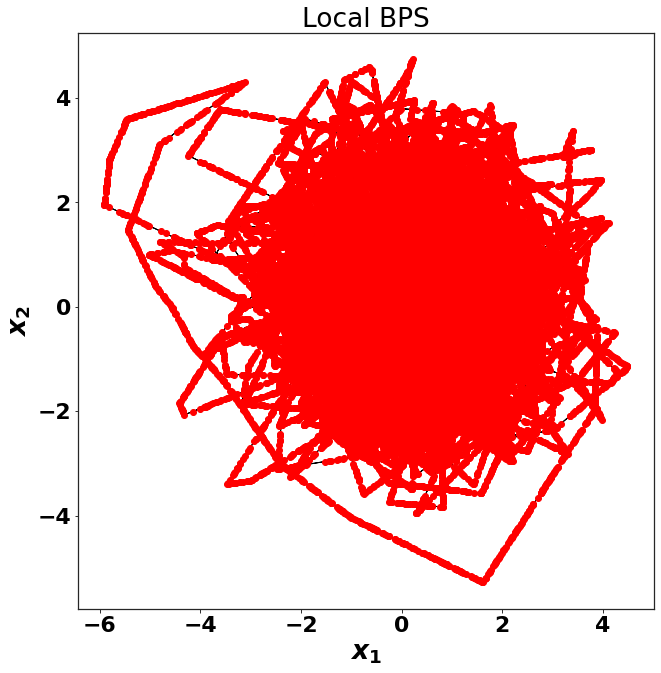

In [15]:
x1,v1,t1=get_xtv(res,2)
x2,v2,t2=get_xtv(res,3)
burnin = 4000
plot_limit = 100000
fig_size = (10,10)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

font = {
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)


fig = plt.figure(figsize=fig_size,frameon =True)
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])
ax.set_title("Local BPS")
ax.set_xlabel("$x_1$",fontsize='large', fontweight='bold')
ax.set_ylabel("$x_2$",fontsize='large', fontweight='bold')
arrow_plot(x1[burnin:burnin+plot_limit],x2[burnin:burnin+plot_limit], head_length=0.01,head_width=0.01)
fig.savefig('./local_bps.eps', format='eps', dpi=1200)



In [16]:
x1,v1,t1=get_xtv(res[1000:],2)

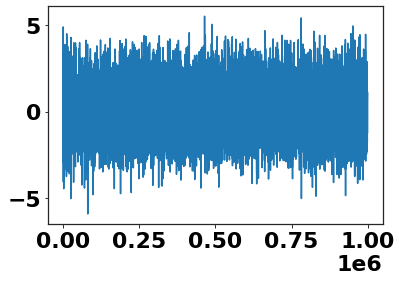

In [17]:
plt.plot(x1)

In [18]:
np.mean(x1)

0.15381303467722662

In [19]:
np.std(x1)

1.3297388475320644